## Le but de notre projet est d'implémenter le ridge de façon paralléliser 

Plan prévu :

- Ecrire une fonction qui génère les données (comme en opti)
- Implémenter une première version d'optimisation du ridge (non parallélisée)
- Essayer de faire une fonction plus optimisée avec cython par exemple
- Ecrire un peu de théorie sur le ridge para 
- utilisation de MPI allreduce ou OpenMP (les trucs dans le genre)
- implémentation de l'algo 
- Comparaison des algos + plots

In [1]:
#On importe les librairies
import numpy as np
import matplotlib.pyplot as plt

## 1) Générer des données sparse pour une régresssion lineaire

In [2]:
from simulateur_donnees import *

In [3]:
d = 50              #nb features
n = 10000           #nb samples


A, b, x_model_truth = get_data(d, n)

print('La dimension de A est :', A.shape ,'\n La dimension de b est :', b.shape)

La dimension de A est : (10000, 50) 
 La dimension de b est : (10000,)


Text(0.5, 1.0, 'Valeur des vrais coefficients des features')

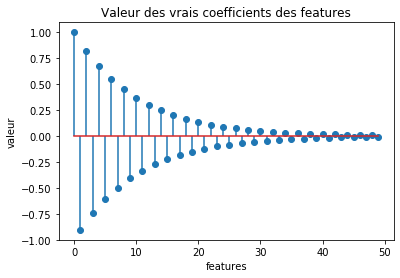

In [4]:
plt.stem(x_model_truth, use_line_collection=True)
plt.xlabel('features')
plt.ylabel('valeur')
plt.title('Valeur des vrais coefficients des features')

## Implémentation d'un algo d'optimisation pour résoudre ce problème 

We want to minimize
$$
\frac 1n \sum_{i=1}^n \ell(a_i^\top x, b_i) + \frac \lambda 2 \|x\|_2^2
$$
where
- $\ell(z, b) = \frac 12 (b - z)^2$ (least-squares regression)

### Ecriture de l'algorithme SGD

In [5]:
from SGD_non_para import *

Mesurons le temps temps d'execution de l'algorithme

In [6]:
import time

In [7]:
debut = time.time()
w_solu, w_list = sgd(x_init=np.ones(len(x_model_truth)), n=n, n_epochs=300, size_batch=50,
                     A=A, b=b, lbda=0.1, step=0.1)
fin = time.time()
print(fin-debut,'s')

142.19456815719604 s


Text(0.5, 1.0, 'Erreur absolue par coefficient')

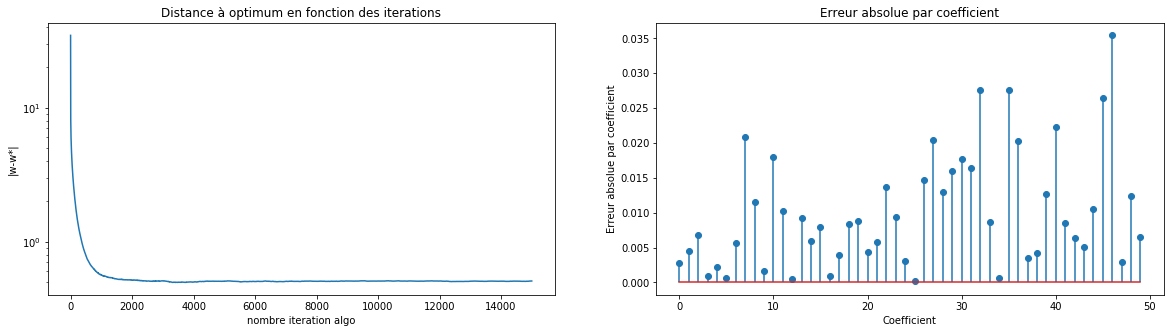

In [8]:
# On plot la 
list_erreur_temps = [sum(abs(vec - x_model_truth)) for vec in w_list]


plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.semilogy(list_erreur_temps)
plt.xlabel('nombre iteration algo')
plt.ylabel('|w-w*|')
plt.title('Distance à optimum en fonction des iterations')


plt.subplot(1,2,2)
plt.stem(abs(w_solu - x_model_truth), use_line_collection=True)
plt.xlabel('Coefficient')
plt.ylabel('Erreur absolue par coefficient')
plt.title('Erreur absolue par coefficient')

In [9]:
print('erreur absolue entre deux points est de ', sum(abs(w_solu - x_model_truth)) / len(w_solu)) 

erreur absolue entre deux points est de  0.010153083295789518


In [10]:
from SGD_para import *

In [11]:
debut = time.time()

if __name__=="__main__":
    results = sgd_para_run(x_init=np.ones(len(x_model_truth)), n=n, n_epochs=300, size_batch=50,
                     A=A, b=b, lbda=0.1)
    w_solu = (results[0][0] + results[1][0]) / 2
    w_list = (np.array(results[0][1]) + np.array(results[1][1])) / 2
fin = time.time()
print(fin-debut,'s')

36.266834020614624 s


Text(0.5, 1.0, 'Erreur absolue par coefficient')

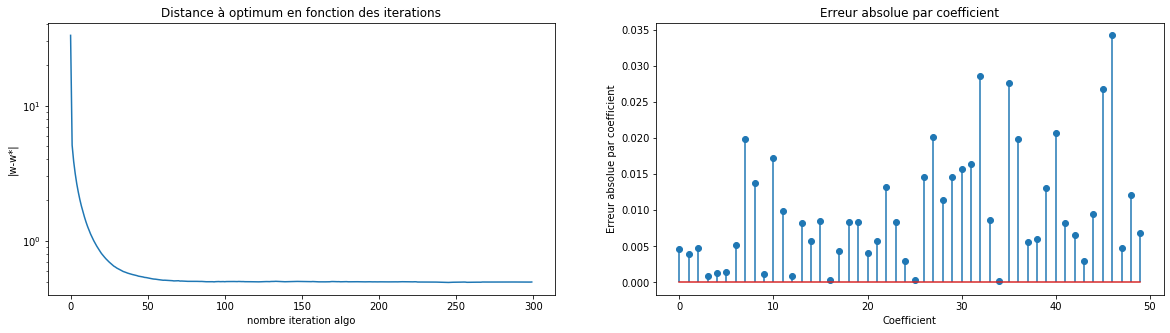

In [12]:
# On plot la 
list_erreur_temps = [sum(abs(vec - x_model_truth)) for vec in w_list]


plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.semilogy(list_erreur_temps)
plt.xlabel('nombre iteration algo')
plt.ylabel('|w-w*|')
plt.title('Distance à optimum en fonction des iterations')


plt.subplot(1,2,2)
plt.stem(abs(w_solu - x_model_truth), use_line_collection=True)
plt.xlabel('Coefficient')
plt.ylabel('Erreur absolue par coefficient')
plt.title('Erreur absolue par coefficient')

In [13]:
print('erreur absolue entre deux points est de ', sum(abs(w_solu - x_model_truth)) / len(w_solu)) 

erreur absolue entre deux points est de  0.009985705248393094


### Plot quand le nombre d'individu augmente

In [14]:
#On Ecrit une fonction qui simule des données pour différents nombres d'individus

def simulateur_donnees(n,d):

    idx = np.arange(d)
    x_model_truth = (-1)**idx * np.exp(-idx / 10.) # Valeur des vrais paramètres 
    A, b = simu_linreg(x_model_truth, n, std=1., corr=0.5)
    return A, b


In [ ]:
#Simulons plusieurs jeux de données où la tailel de nombre de sample varie

list_A = list()
list_b = list()

n_sample = [100, 1000, 2000, 5000, 10000, 15000, 20000, 30000, 40000, 50000]

for sample in n_sample:
    r1, r2 = simulateur_donnees(n=int(sample), d=50)
    list_A.append(r1)
    list_b.append(r2)

In [ ]:
#On peut aussi plot le temps d'executions pour différents n
list_temps_non_para = list()
list_w_solu_non_para = list()

list_temps_para = list()
list_w_solu_para = list()

for ii in range(len(n_sample)):
    
    print(ii, 'eme itération')
    n = n_sample[ii]
    A, b = list_A[ii], list_b[ii]
    iis = np.random.randint(0, int(n), int(n * 100))
    
    debut = time.time()
    w_sol_non_para, _ = sgd(x_init=np.ones(len(x_model_truth)), n=n, n_epochs=100, A=A, b=b, lbda=0.1, step=0.1,size_batch=10)
    list_w_solu_non_para.append(w_sol_non_para)
    fin = time.time()
    list_temps_non_para.append(fin-debut)
    
    debut = time.time()
    results = sgd_para_run(x_init=np.ones(len(x_model_truth)), n=n, n_epochs=100, size_batch=10, A=A, b=b, lbda=0.1)
    w_sol_para = (results[0][0] + results[1][0]) / 2
    list_w_solu_non_para.append(w_sol_para)
    fin = time.time()
    list_temps_para.append(fin-debut)

0 eme itération
1 eme itération
2 eme itération
3 eme itération
4 eme itération
5 eme itération
6 eme itération
7 eme itération
8 eme itération


In [ ]:
#Plot
n_sample_string = ['100', '1000', '2000', '5000', '10000', '15000', '20000', '30000', '40000', '50000']
list_precision_non_para = [sum(abs(vec_solu - x_model_truth)) / len(vec_solu) for vec_solu in list_w_solu_non_para]
list_precision_para = [sum(abs(vec_solu - x_model_truth)) / len(vec_solu) for vec_solu in list_w_solu_para]


plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(n_sample_string, list_temps_non_para, 'o-', 'b')
plt.plot(n_sample_string, list_temps_para, 'o-', 'r')
plt.xlabel('nombre individu')
plt.ylabel('temps execution en s')
plt.title('Temps execution de algo pour different n')

plt.subplot(1,2,2)
plt.plot(n_sample_string, list_precision_non_para, 'o-', 'b')
plt.plot(n_sample_string, list_precision_para, 'o-', 'r')
plt.xlabel('nombre individu')
plt.ylabel('erreur absolue moyenne')
plt.title('erreur absolue moyenne en fonction du nombre individu')
